In [7]:
%%writefile Spectrogram.py

# import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime 
from numpy import fft 
from numpy import exp, pi
from mpi4py import MPI

def signal(n_timestamps = 4096):
    t = np.linspace(-20*2*pi, 20*2*pi, n_timestamps)
    y = np.sin(t)*exp(-t**2/2/20**2)               # generate first  wave packets of harmonic signal
    y = y + np.sin(3*t)*exp(-(t-5*2*pi)**2/2/20**2)  # add      second wave packets of harmonic signal
    y = y + np.sin(5*t)*exp(-(t-10*2*pi)**2/2/10**2) # add      third  wave packets of harmonic signal
    y = y + np.sin(4*t)*exp(-(t-7*2*pi)**2/2/20**2)
    
    return t, y

def window_function(t, window_position, window_width):
    return exp(-(t - window_position)**2/2/window_width**2)

def get_specgram_data_t_window_positions(t, y, t_window_positions, window_width, nwindowsteps=1000):
    specgram = np.empty([len(t), len(t_window_positions)])

    for i,t_window_position in enumerate(t_window_positions):
        y_window = y*window_function(t, t_window_position, window_width)
        specgram[:, i]=abs(fft.fft(y_window))

    return specgram

def fig(x, y, z, title, xlabel, ylabel, grid_active=False, fig_x_size=15, fig_y_size=10, font_param=20):
    w = fft.fftfreq(len(y), d=(t[1]-t[0])/2/pi)
    plt.figure(figsize=(fig_x_size, fig_y_size))
    plt.imshow(z, aspect='auto', origin='lower', 
               extent=[min(x)/2/pi, max(x)/2/pi, y[0], 2 * w[int(len(x)/2)-1]])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=font_param)
    plt.title(title, fontsize = font_param * 1.3)
    plt.xlabel(xlabel, fontsize = font_param)
    plt.ylabel(ylabel, fontsize = font_param)
    plt.xticks(fontsize = font_param)
    plt.yticks(fontsize = font_param)
    plt.grid(grid_active)
    plt.ylim(0, 10)
    plt.savefig(title+'.png', bbox_inches='tight', dpi=300)

    
startTime = datetime.now()    
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nprocs = comm.Get_size()

t, y = signal(50000)
t_window_positions = np.linspace(-20*2*pi, 20*2*pi, 1000)
slice_index = np.linspace(0, t_window_positions.shape[0], nprocs+1, endpoint=False, dtype=int)
slice_index[-1] = t_window_positions.shape[0]
spectrogram = get_specgram_data_t_window_positions(t, y, 
                                t_window_positions[slice_index[rank]:slice_index[rank+1]],
                                window_width=20, nwindowsteps=1000)

data_from_proc = comm.gather(spectrogram, root=0)

if rank == 0:
    res_spectrogram = np.hstack(data_from_proc)
    print(datetime.now() - startTime)

Writing Spectrogram.py


In [2]:
!pip install mpi4py

     |████████████████████████████████| 2.5 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185324 sha256=f6a40ac48dc9dd77aa3080180c33153eb9502524cdaaf0d2981be9f4fa7b4720
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


In [11]:
import mpi4py
import numpy as np
import matplotlib.pyplot as plt
pr = np.arange(1, 16)
sp_time = []

for i in pr:
    time = !mpiexec --allow-run-as-root -np {i} python Spectrogram.py
    sp_time.append(float(time[0][-8:]))
    print (time[0][-8:])

5.427100
5.445262
5.895674
6.674186
7.222794
7.353419
7.905567
7.650960
8.038697
8.193297
8.471323
8.787670
8.913600
9.078092
9.141319


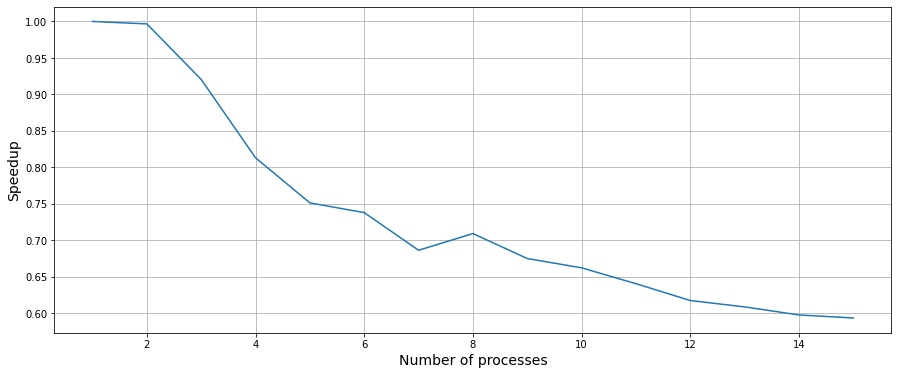

In [12]:
plt.figure(figsize=(15, 6))
plt.plot(pr, sp_time[0] / np.array(sp_time))
plt.xlabel('Number of processes', size=14)
plt.ylabel('Speedup', size=14)
plt.grid(True);